# Notebook to analyze the results for the 3 classes classification model

**Owner:** Fabricio Crespo

## Preparing the data

- Mounting Google Drive Unit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

RuntimeError: ignored

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 18 23:33:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
''' data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
} '''


''' data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
} '''

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/training/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
output_dim=len(class_names)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [ ]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


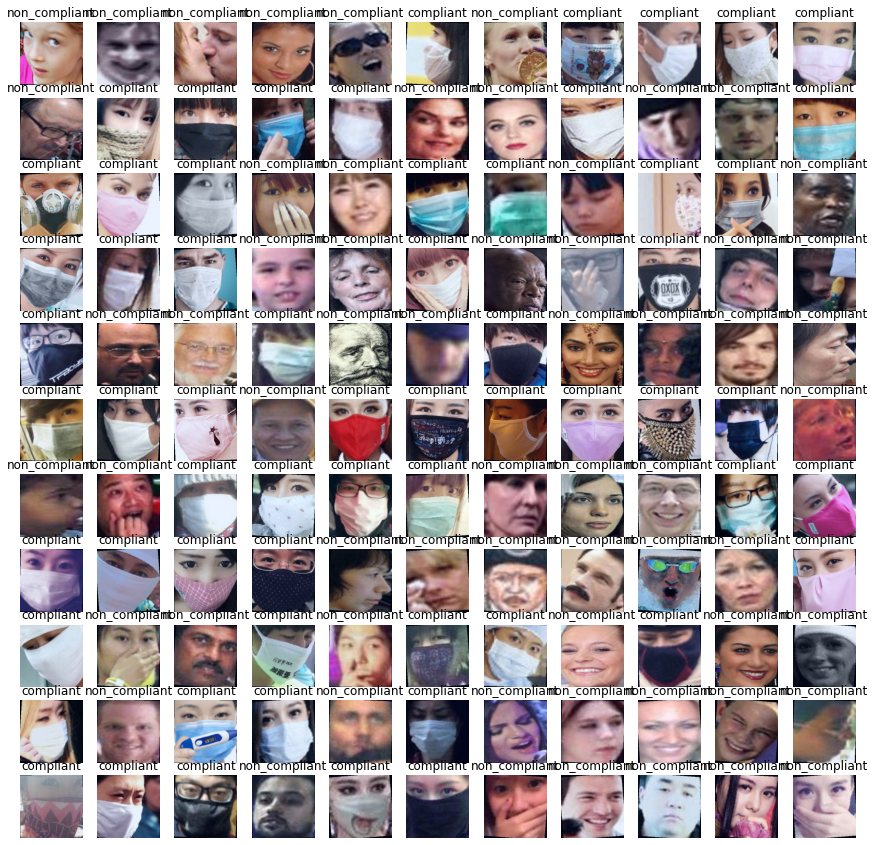

In [ ]:
N_IMAGES = 25

images, labels = next(iter(dataloaders['train']))

classes = image_datasets['train'].classes

plot_images(images, labels, classes)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [ ]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [ ]:
resnet18 = ResNet(resnet18_config, output_dim)
resnet34 = ResNet(resnet34_config, output_dim)

In [ ]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [ ]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
resnet50 = ResNet(resnet50_config, output_dim)
resnet101 = ResNet(resnet101_config, output_dim)
resnet152 = ResNet(resnet152_config, output_dim)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Load the custom pre-trained model.

In [ ]:
custom_model_path='/content/drive/MyDrive/TESIS/after_TicEc/Classification/modelos_diciembre_2021/resnet-18-Cross_ADAGRAD_10epochs_dataset3_2clases_gender_transforms.pt'

model = torch.load(custom_model_path)

In [ ]:
OUTPUT_DIM = 2
model_to_train= ResNet(resnet18_config, OUTPUT_DIM)
#pretrained_model = models.resnet34(pretrained = True)
IN_FEATURES = model_to_train.fc.in_features 

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model_to_train.fc = fc

model_to_train.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model_to_train.fc.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model_to_train.to(device)
criterion = criterion.to(device)

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model_to_train, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(dataloaders['train'], END_LR, NUM_ITER)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

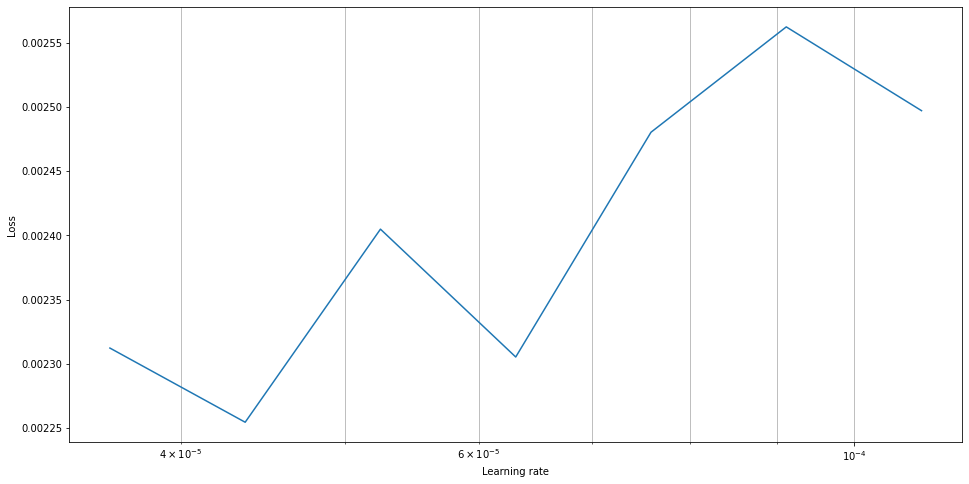

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
torch.save(model_to_train.state_dict(), 'resnet-18-Cross_ADAGRAD_15epochs_dataset4_2clases_dict_gender_transforms.pt')

In [ ]:
!cp resnet-18-Cross_ADAGRAD_15epochs_dataset4_3clases_dict_gender_transforms.pt /content/drive/MyDrive/TESIS/after_TicEc/Classification/modelos_diciembre_2021

In [ ]:
import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
#test_directory="/content/dataset_complete_aug60k_separated/test/"
test_directory="/content/test/"
#test_directory="/content/dataset_age_limpio_5k_separated/test/"
#test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/short-test/"

# Batch size
bs = 256

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

Classes:  {0: 'compliant', 1: 'non_compliant'}


In [ ]:
custom_model_path='resnet-18-Cross_ADAGRAD_15epochs_dataset4_2clases_dict_gender_transforms.pt'

model.load_state_dict(torch.load(custom_model_path))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_data_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.016 | Test Acc @1:  99.49% | Test Acc @5: 100.00%


Classes:  {0: 'compliant', 1: 'non_compliant'}
Number of faces:  4926
El numero de predictions coincide con el size del dataset
<class 'list'>
<class 'list'>
Len labels: 4926
Len predictions: 4926
Test accuracy : 0.9959399103150346
Model: resnet-18-Cross_ADAGRAD_10epochs_dataset3_2clases_gender_transforms
               precision    recall  f1-score   support

    Compliant       1.00      0.99      1.00      2463
Non-Compliant       0.99      1.00      1.00      2463

     accuracy                           1.00      4926
    macro avg       1.00      1.00      1.00      4926
 weighted avg       1.00      1.00      1.00      4926



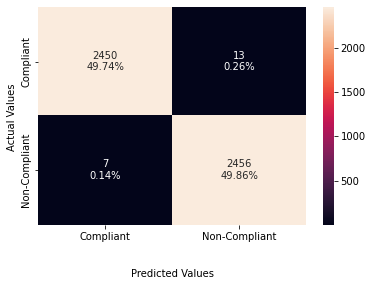

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
from sklearn.metrics import classification_report

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data

#Original 
image_transforms = { 
    'test': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}


''' image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
} '''

''' image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
} '''

''' image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
} '''
# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
#test_directory="/content/dataset_complete_aug60k_separated/test/"
test_directory="/content/test/"
#test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/short-test/"

# Batch size
bs = 256

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    #----CONFUSION MATRIX VARIABLES----
    #tp=0
    #fp=0
    #fn=0
    #tn=0
    #cont_nulo=0
    #global_labels=None
    #global_predictions=None
    global_labels=torch.empty((128), dtype=torch.int32, device = 'cuda')
    global_predictions=torch.empty((128), dtype=torch.int32, device = 'cuda')
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            global_labels=torch.cat((global_labels,labels), 0)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            global_predictions=torch.cat((global_predictions,predictions), 0)

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

    # ==================CONFUSION MATRIX======================================#
    predictions = []
    labels = []

    predictions=global_predictions.cpu().detach().numpy()
    labels=global_labels.cpu().detach().numpy()

    predictions = list(filter(lambda x : x in range(0,num_classes),   predictions)) 
    labels = list(filter(lambda x : x in range(0,num_classes),   labels))

    if len(predictions)==test_data_size:
      print("El numero de predictions coincide con el size del dataset")
    else:
      print("El numero de predictions no coincide con el size del dataset")

    #del global_predictions
    #del global_labels

    # 1st approach
    ''' for i in range(len(global_predictions)):
      predictions.append(global_predictions.data[i].item)
      labels.append(global_labels.data[i].item)
    print(f"len de predictions={len(predictions)}")
    print(f"len de labels={len(labels)}") '''
    
    ''' combinations=zip(labels,predictions)
    combinations=list(combinations)
    
    w, h = 6, 6
    matrix = [[0 for x in range(w)] for y in range(h)]

    for i, j in combinations:
      matrix[i][j]+=1
    #print(matrix)

    import seaborn as sn
    import pandas as pd
    #import matplotlib.pyplot as plt
    df_cm = pd.DataFrame(matrix, index = [i for i in ['11_18','19_35','1_10','36_50', '51_64','gte_65']],
                      columns = [i for i in ['11_18','19_35','1_10','36_50', '51_64','gte_65']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True) '''

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    #Generate the confusion matrix
    print(type(labels))
    print(type(predictions))
    labels_metrics = labels
    matrix = confusion_matrix(labels, predictions)
    print(f'Len labels: {len(labels)}')
    #print(labels)
    #print(predictions)
    print(f'Len predictions: {len(predictions)}')
    #Swap columns and rows to get order data
    #matrix[:, [2,0]]=matrix[:, [0,2]] 
    #matrix[:, [2,1]]=matrix[:, [1,2]] 
    #matrix[[2,0], :]=matrix[[0,2], :] 
    #matrix[[2,1], :]=matrix[[1,2], :]

    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        matrix.flatten()/np.sum(matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #labels=['11_18','19_35','1_10','36_50', '51_64','gte_65']
    #sns.heatmap(matrix, annot=labels, fmt='')
    #plt.figure(figsize = (10,7)) 
    ax = sns.heatmap(matrix, annot=labels, fmt='')
    ax.set_xlabel('\n\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['Compliant','Non-Compliant'])
    ax.yaxis.set_ticklabels(['Compliant','Non-Compliant'])
    
    # ==================END MATRIX======================================#
       
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc,labels_metrics, predictions


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
#model_file = '/content/drive/MyDrive/TESIS/after_TicEc/Classification/modelos_obtenidos/resnet-34-Cross_Adagrad_30_dataset4_3clases.pt'
model_file = '/content/drive/MyDrive/TESIS/after_TicEc/Classification/modelos_diciembre_2021/resnet-18-Cross_ADAGRAD_10epochs_dataset3_2clases_gender_transforms.pt'
if os.path.exists(model_file):    
    model1 = torch.load(model_file)
    model1 = model1.to(device)
    avg_test_acc, labels, predictions = computeTestSetAccuracy(model1, loss_func, test_data_loader, test_data_size)

    print("Test accuracy : " + str(avg_test_acc))
    print(f"Model: {(model_file.split('/')[-1]).split('.')[0]}")

    #=========================METRICS====================================#
    #print(f'Type of labels: {type(labels)}')
    #print(f'Type predictions: {type(predictions)}')
    target_names = ['Compliant','Non-Compliant']
    print(classification_report(labels, predictions, target_names=target_names)) 

else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")




In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_data_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

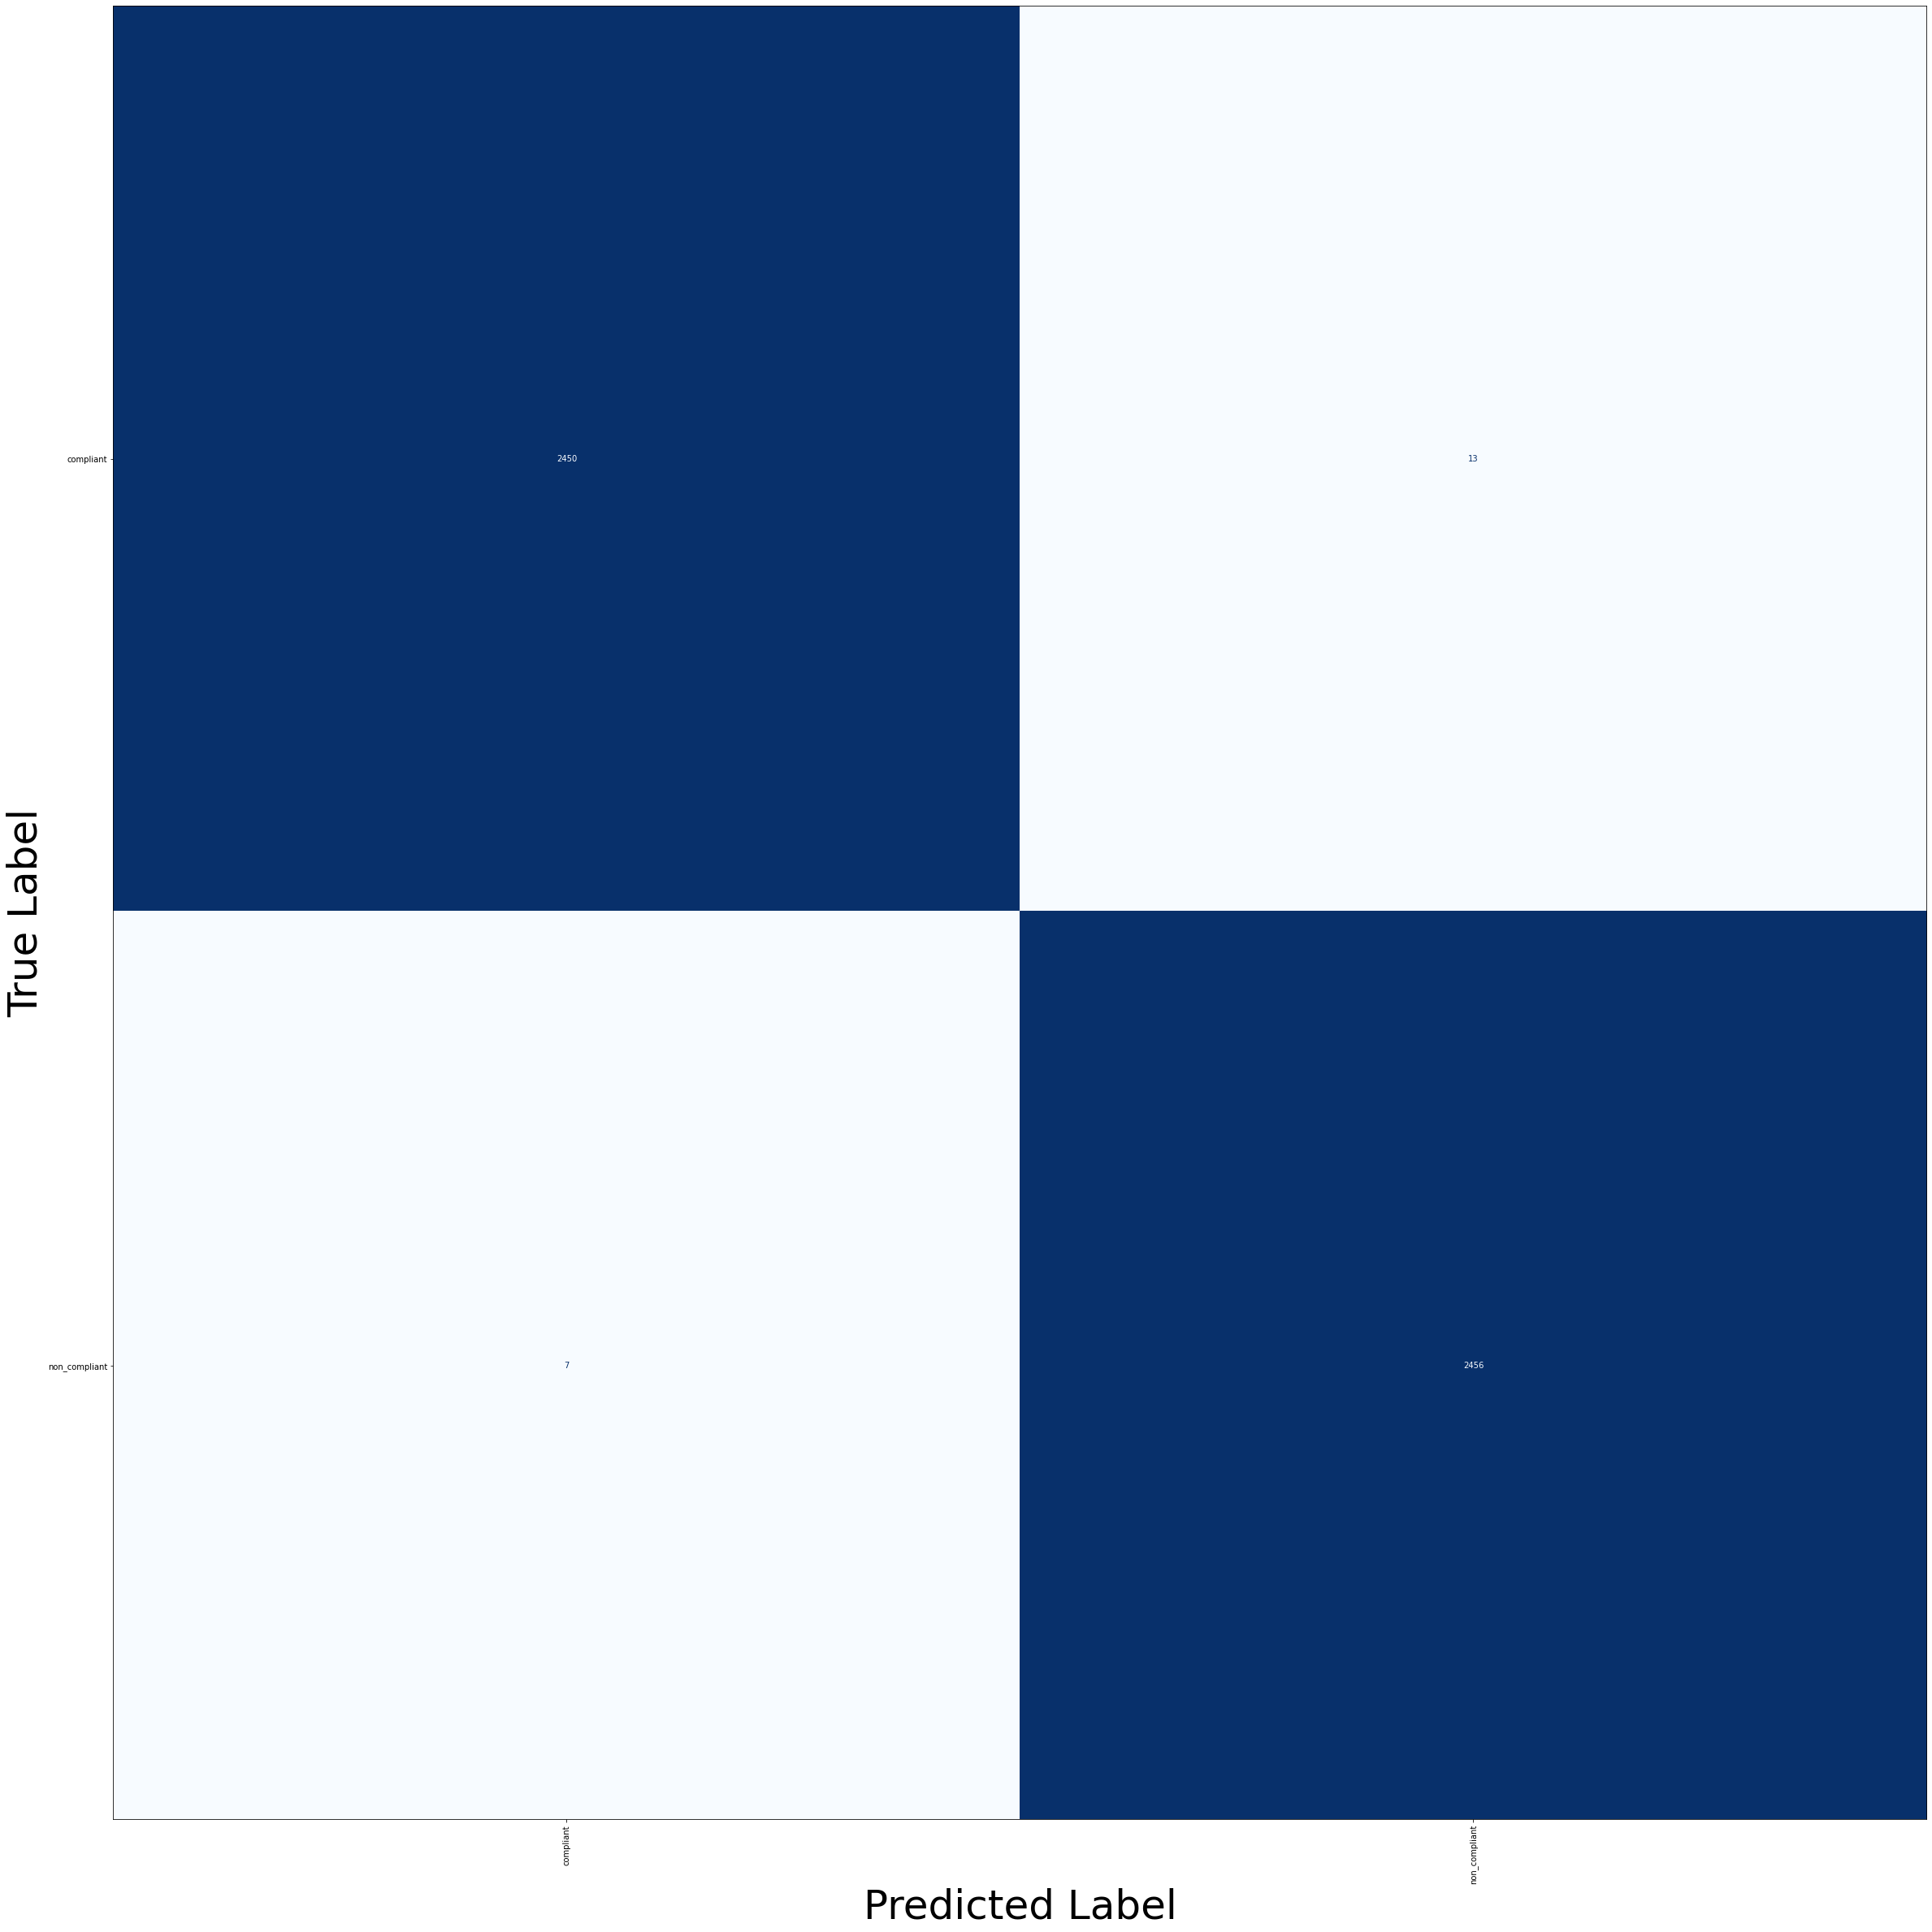

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

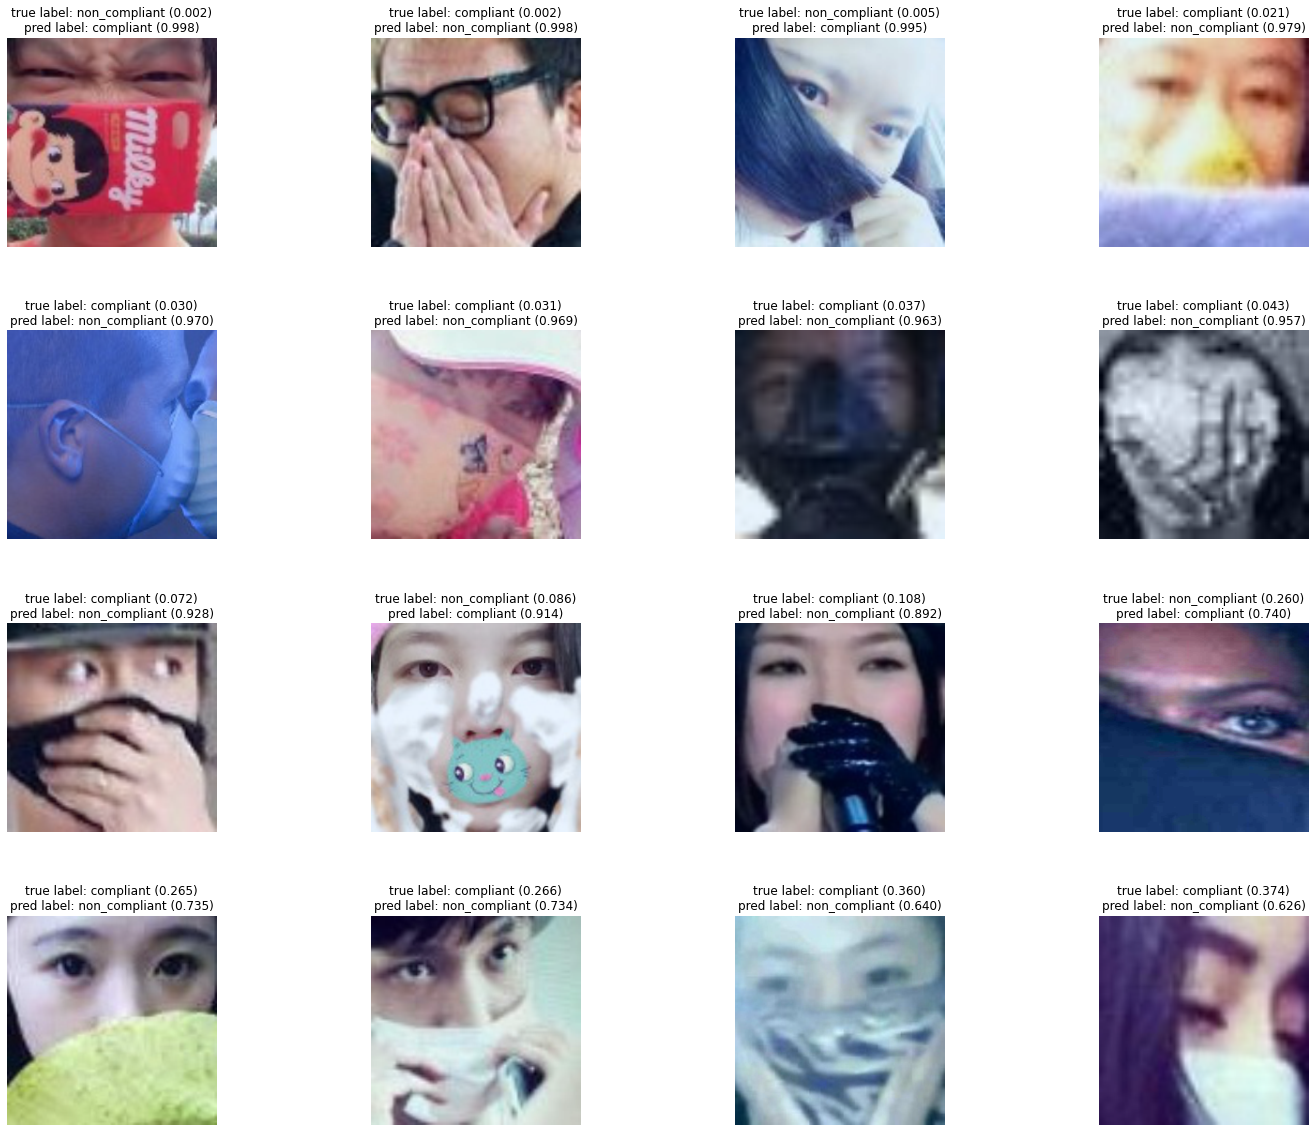

In [ ]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

### Get incorrect examples by class

In [ ]:
def get_incorrect_by_class(incorrect_examples,label):
  incorrect_examples_class=[]
  for i in range(len(incorrect_examples)):
        image, true_label, probs = incorrect_examples[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        if true_class==label:
          incorrect_examples_class.append(incorrect_examples[i])
  return incorrect_examples_class

13


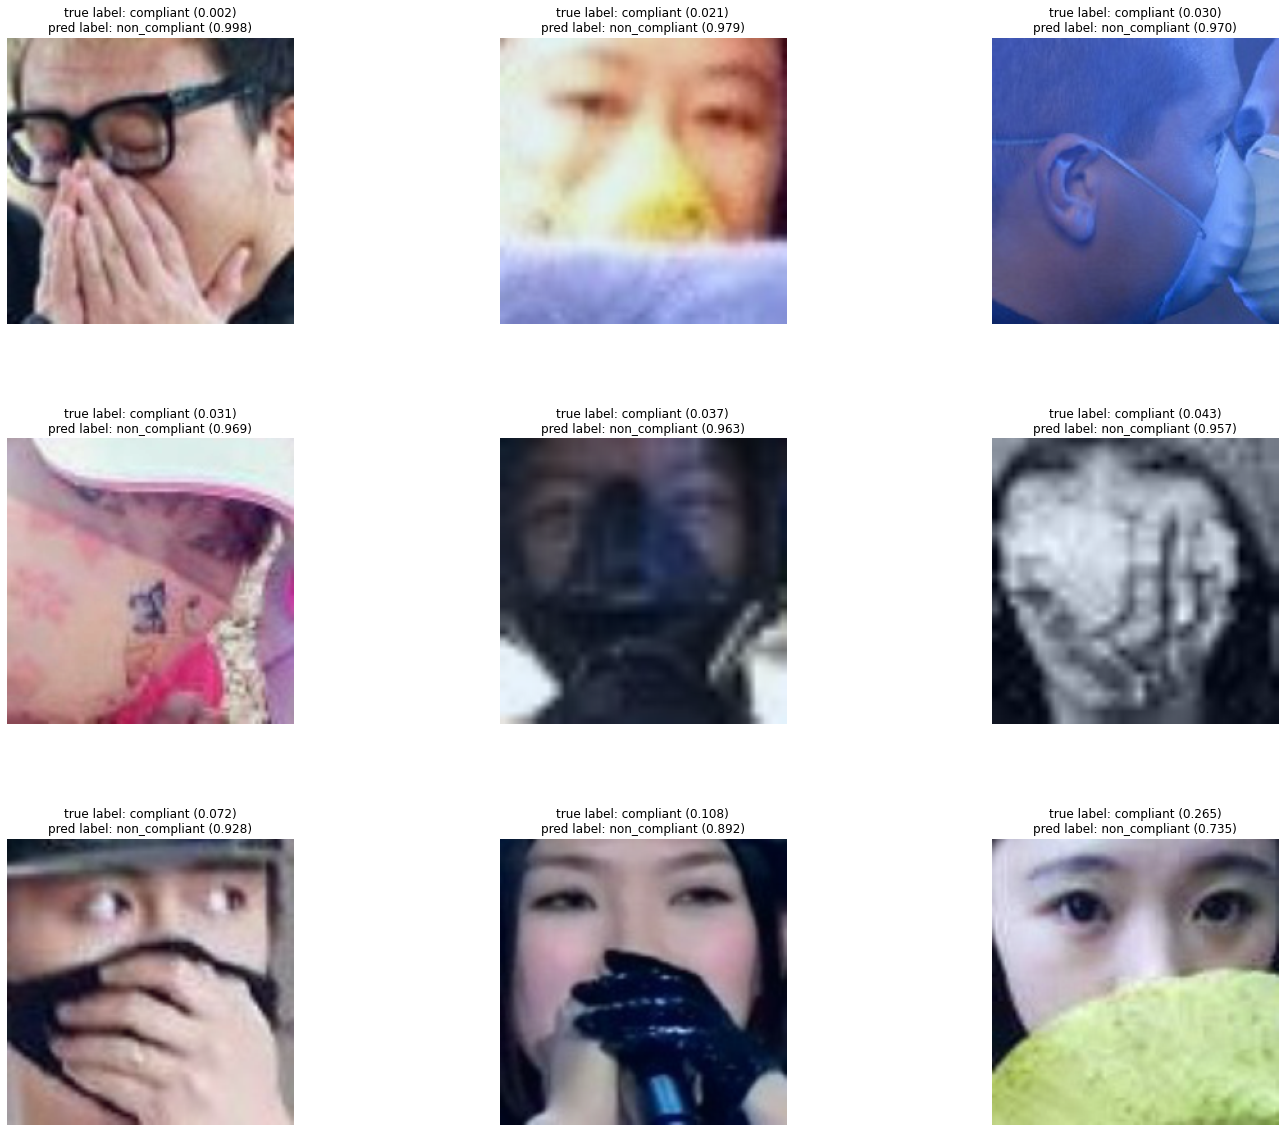

In [ ]:
class_name='compliant'

incorrect_examples_by_class=[]

incorrect_examples_by_class=get_incorrect_by_class(incorrect_examples, class_name)

N_IMAGES = len(incorrect_examples_by_class)
print(N_IMAGES)
plot_most_incorrect(incorrect_examples_by_class, classes, N_IMAGES)

7


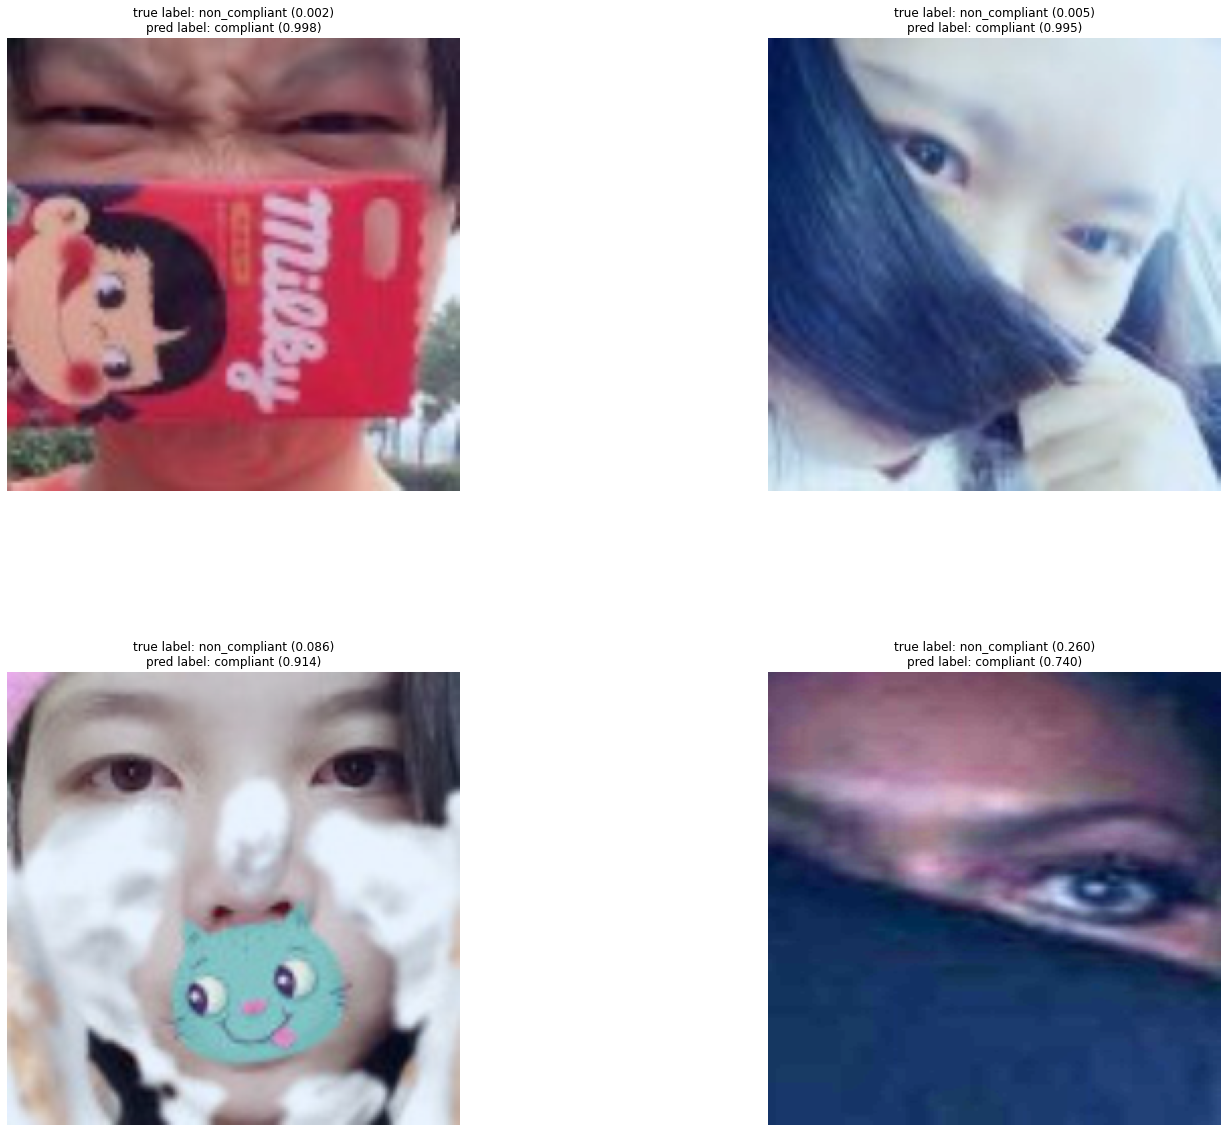

In [ ]:
class_name='non_compliant'

incorrect_examples_by_class=[]

incorrect_examples_by_class=get_incorrect_by_class(incorrect_examples, class_name)

N_IMAGES = len(incorrect_examples_by_class)
print(N_IMAGES)
plot_most_incorrect(incorrect_examples_by_class, classes, N_IMAGES)

## Get representations

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, dataloaders['train'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

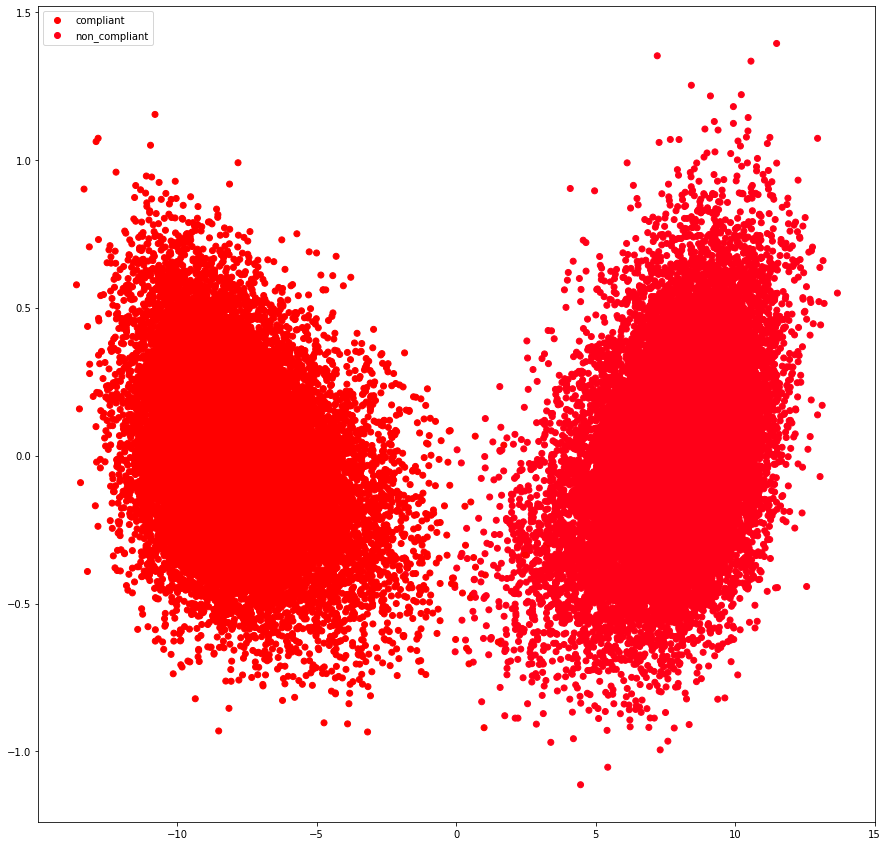

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [ ]:
print(len(outputs))

41874


In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


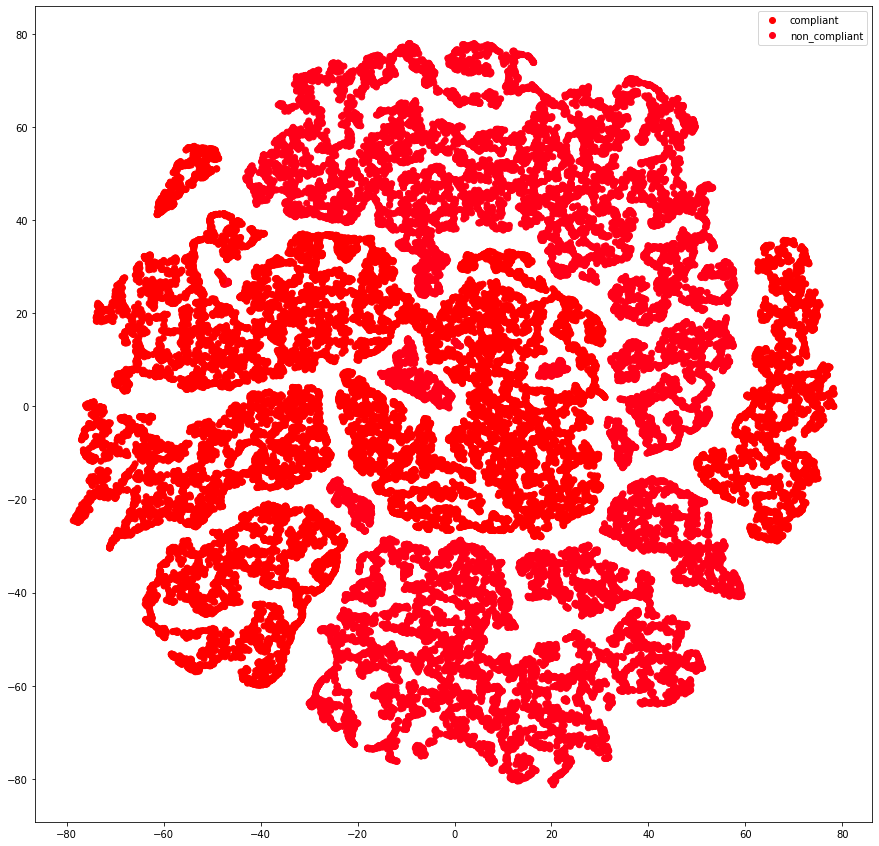

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


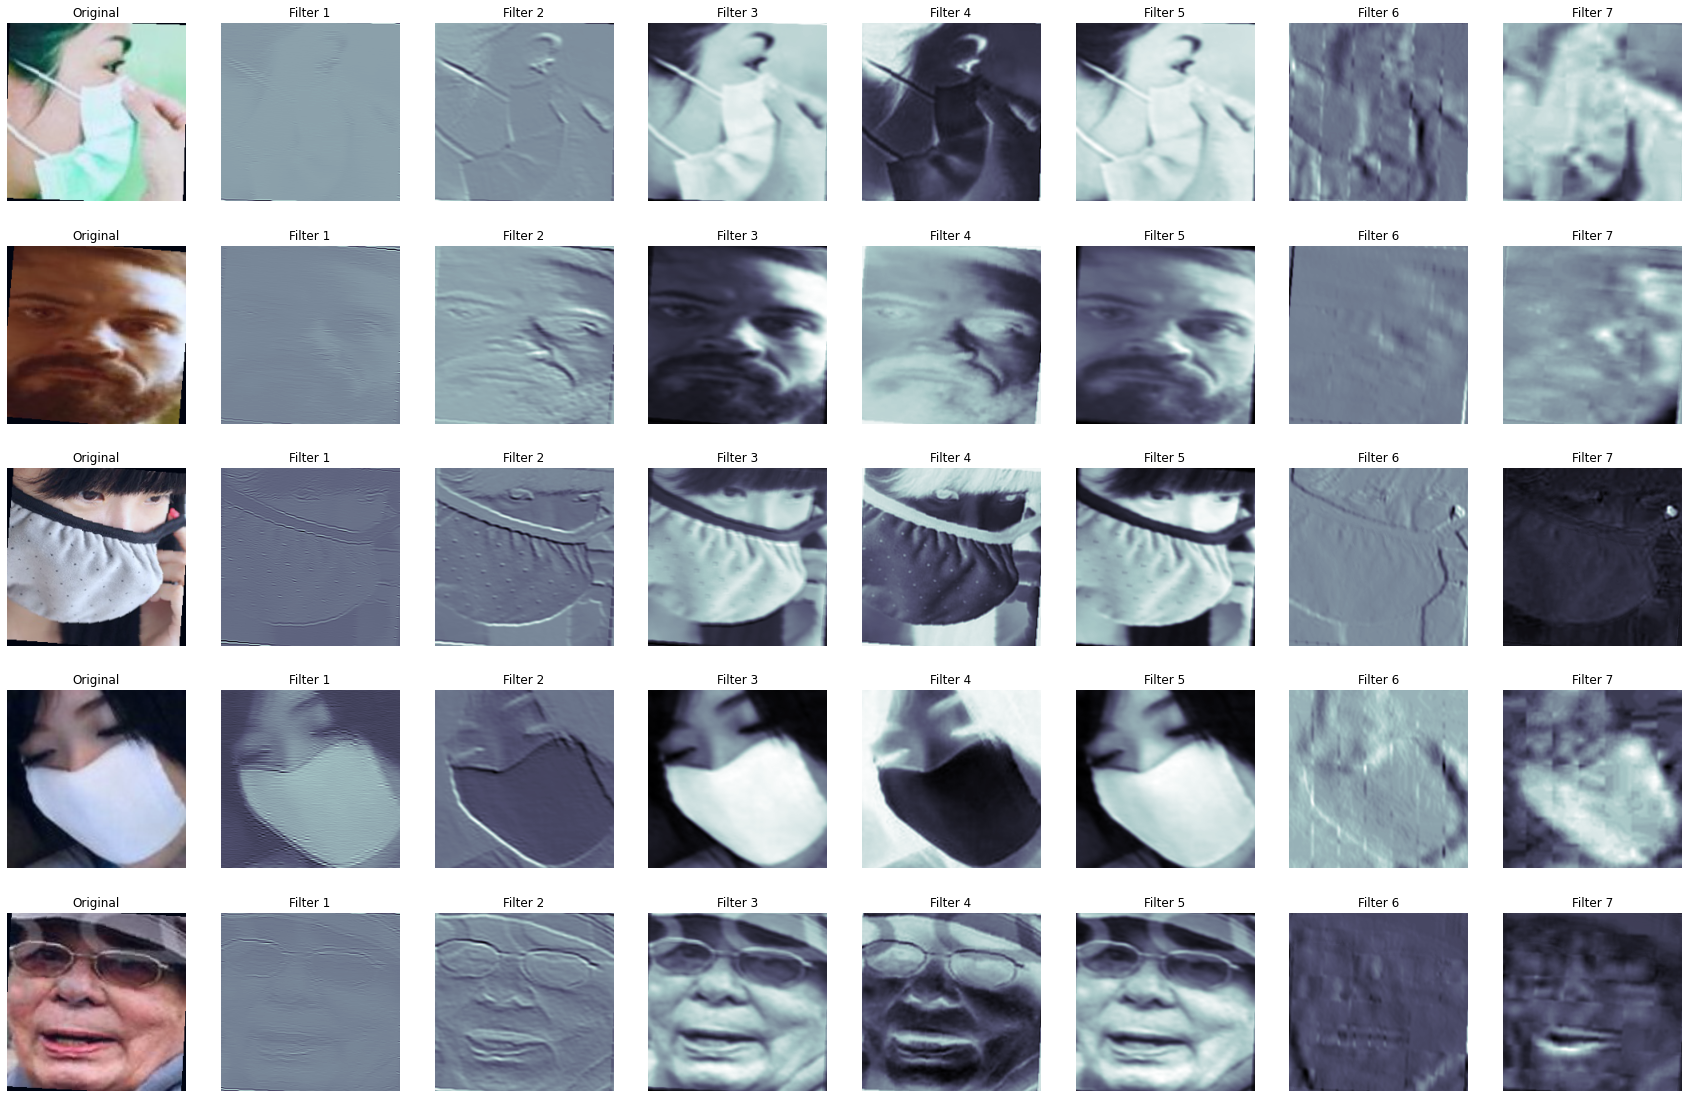

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

#images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
images, labels = next(iter(dataloaders['train']))
images=images[:N_IMAGES]

filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)
#If want all the filters:
#plot_filtered_images(images, filters)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

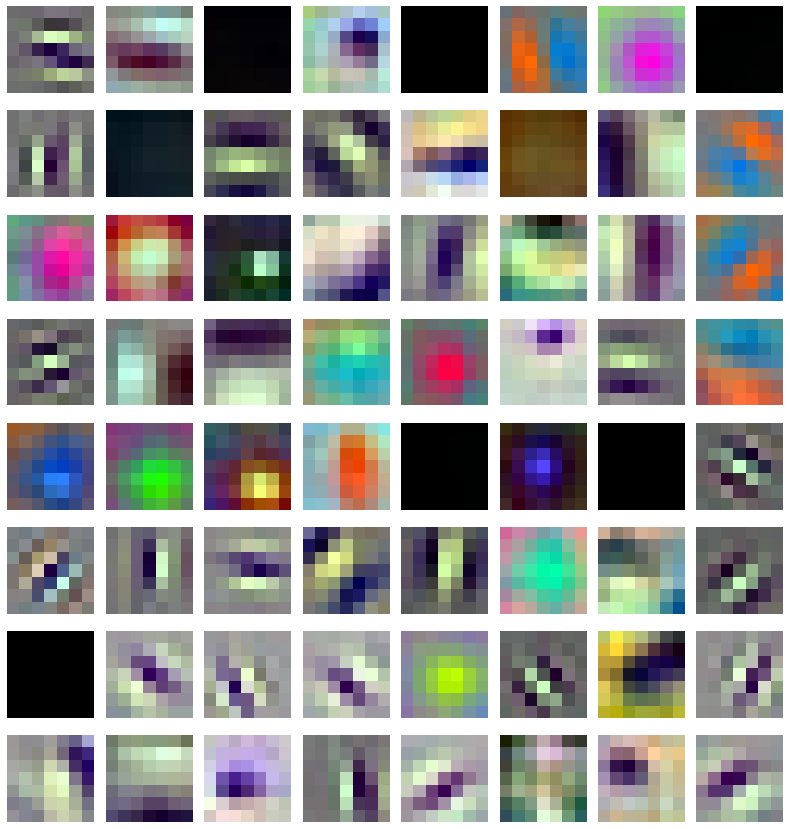

In [ ]:
plot_filters(filters)

## Visualizing Feature Maps using PyTorch

https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573


In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


- We should take upload an image.

In [ ]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = Image.open(str('prueba.jpg'))
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


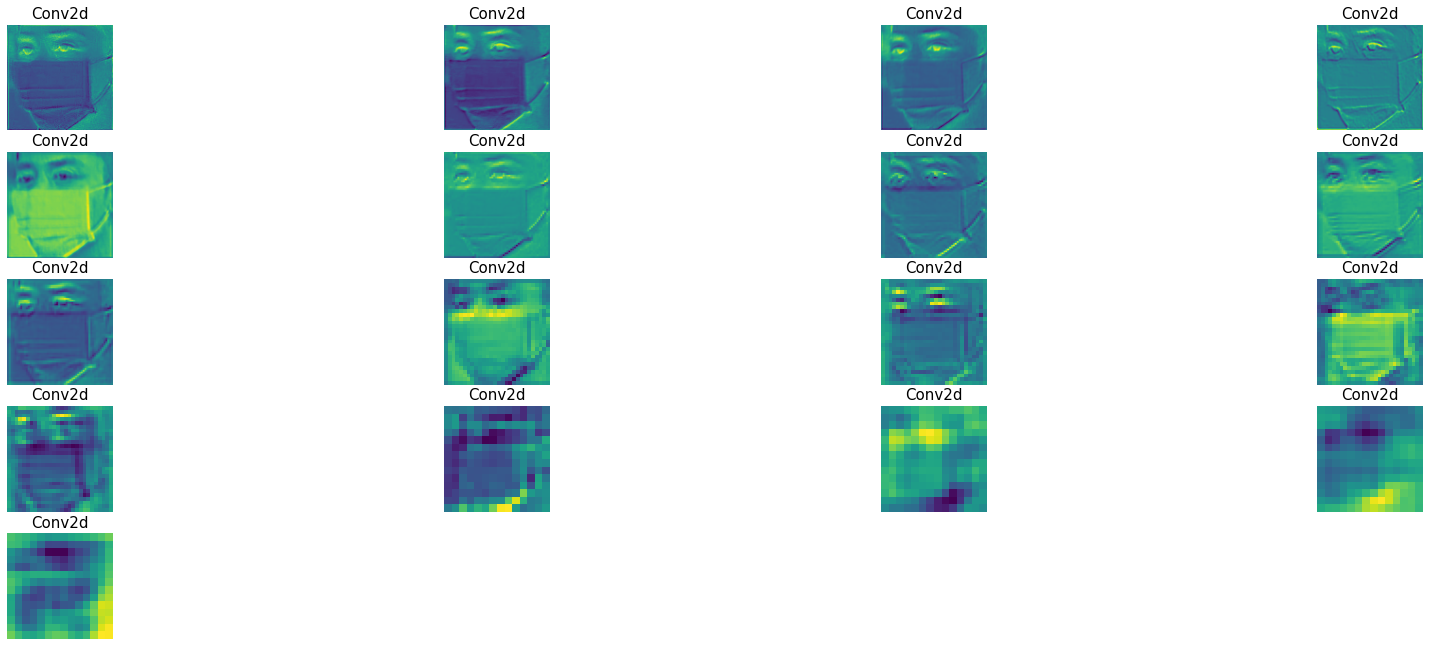

In [ ]:
fig = plt.figure(figsize=(30, 30))
for i in range(len(processed)):
    a = fig.add_subplot(13, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=15)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

## Visualizing Filters 

https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [ ]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])


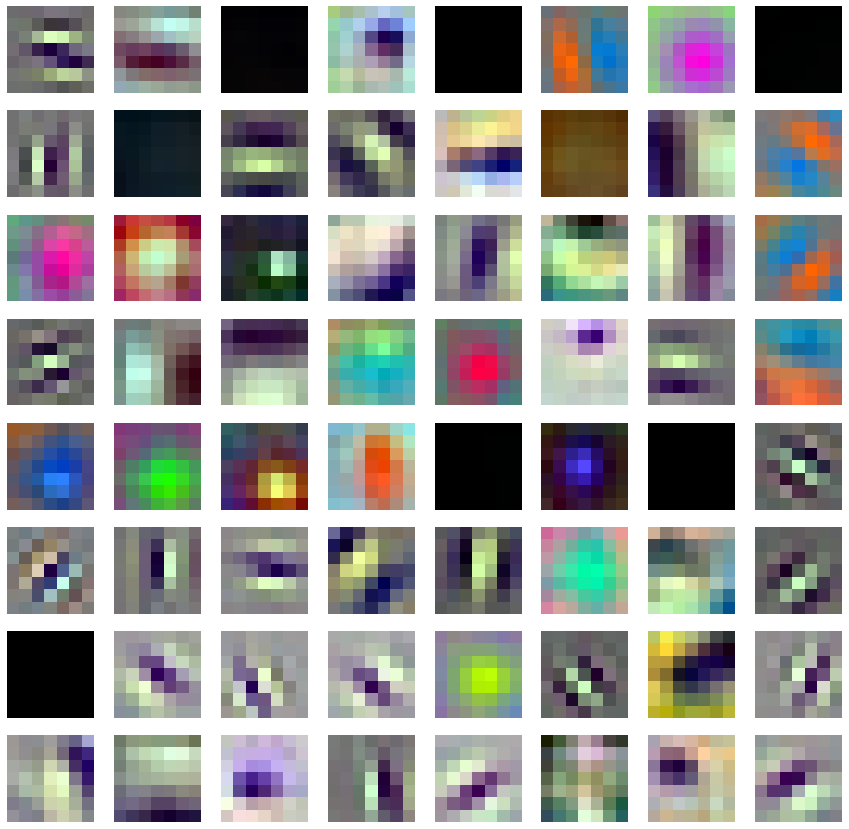

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(15, 15))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    #plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    filter=filter.detach().cpu()
    filter=normalize_image(filter)
    plt.imshow(filter.permute(1, 2, 0).detach().cpu()) #permute let us to get filters in colors.
    plt.axis('off')
    plt.savefig('filter.png')
fig.subplots_adjust(wspace = -0.9)
plt.show()

In [ ]:
print(len(model_weights))

17


## Visualizing the Feature Maps


In [ ]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = Image.open(str('prueba.jpg'))
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

# pass the image through all the layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


torch.Size([64, 112, 112])
Saving layer 0 feature maps...


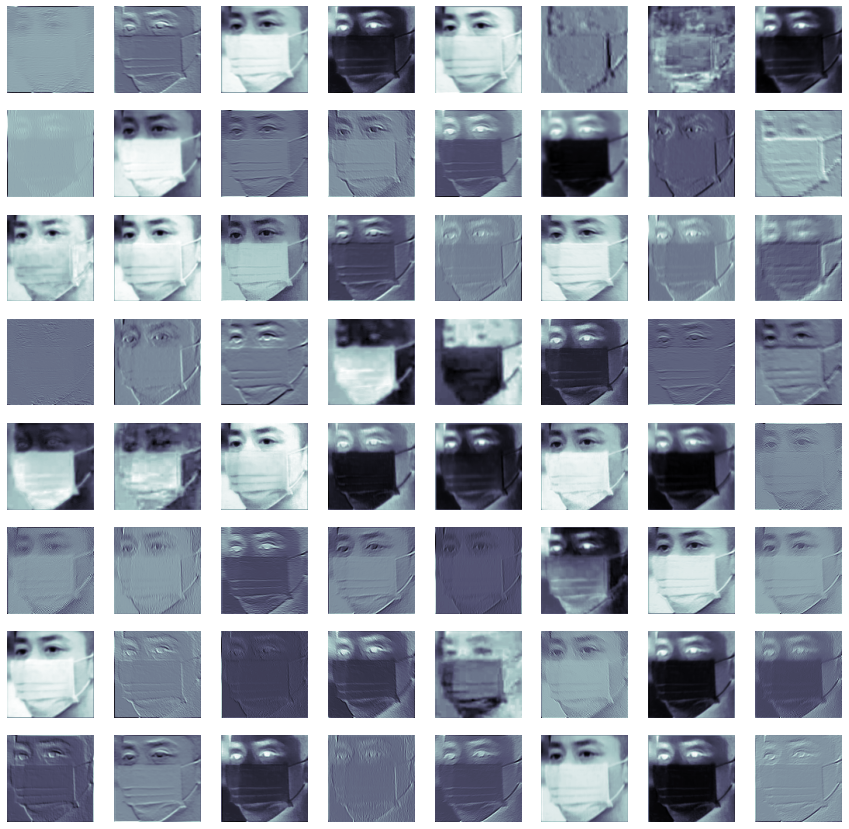

torch.Size([128, 56, 56])
Saving layer 5 feature maps...


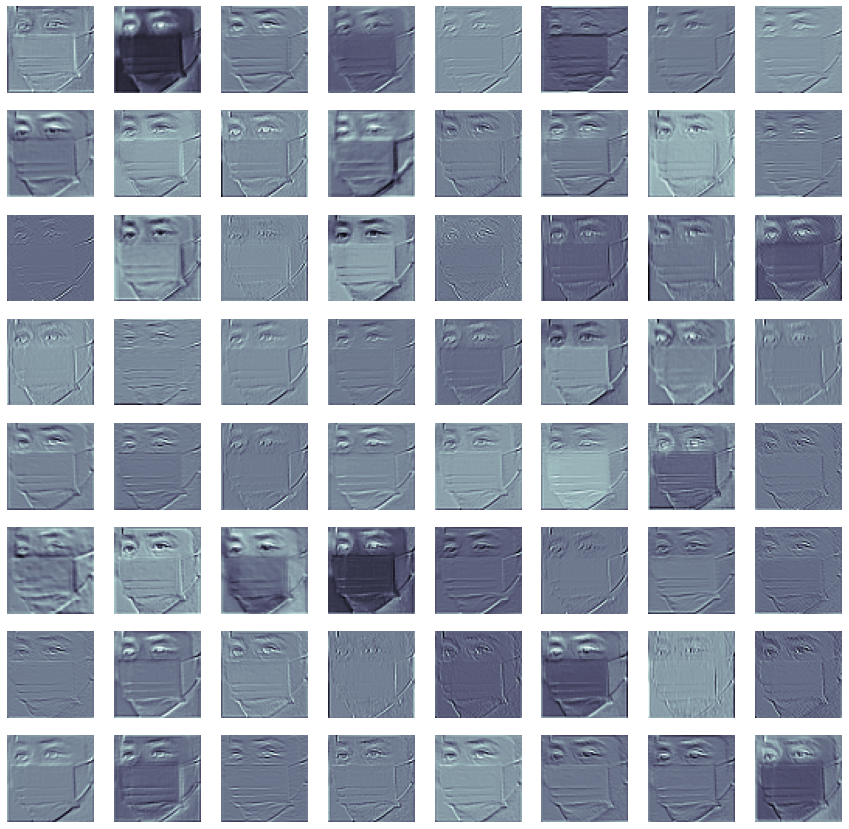

torch.Size([256, 28, 28])
Saving layer 10 feature maps...


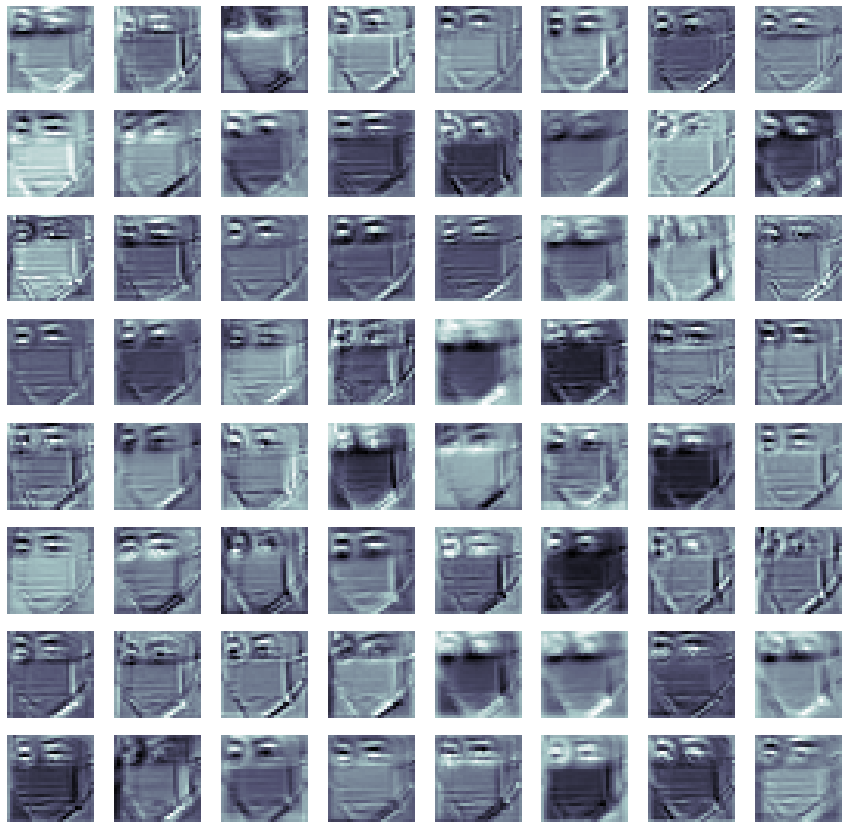

torch.Size([512, 14, 14])
Saving layer 15 feature maps...


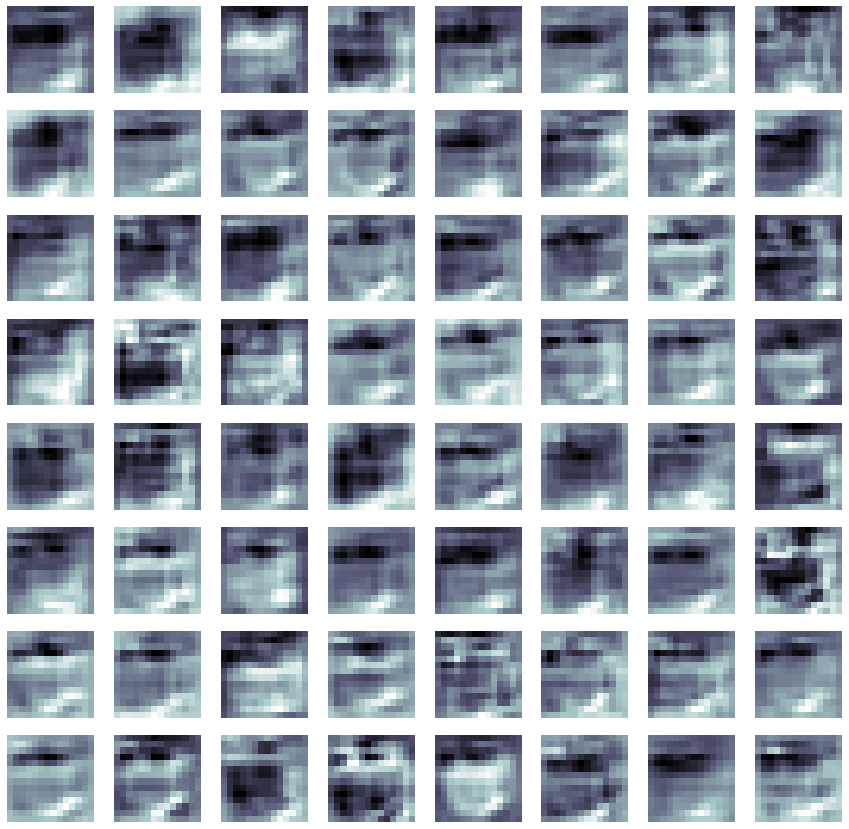

torch.Size([512, 14, 14])
Saving last layer 16 feature maps...


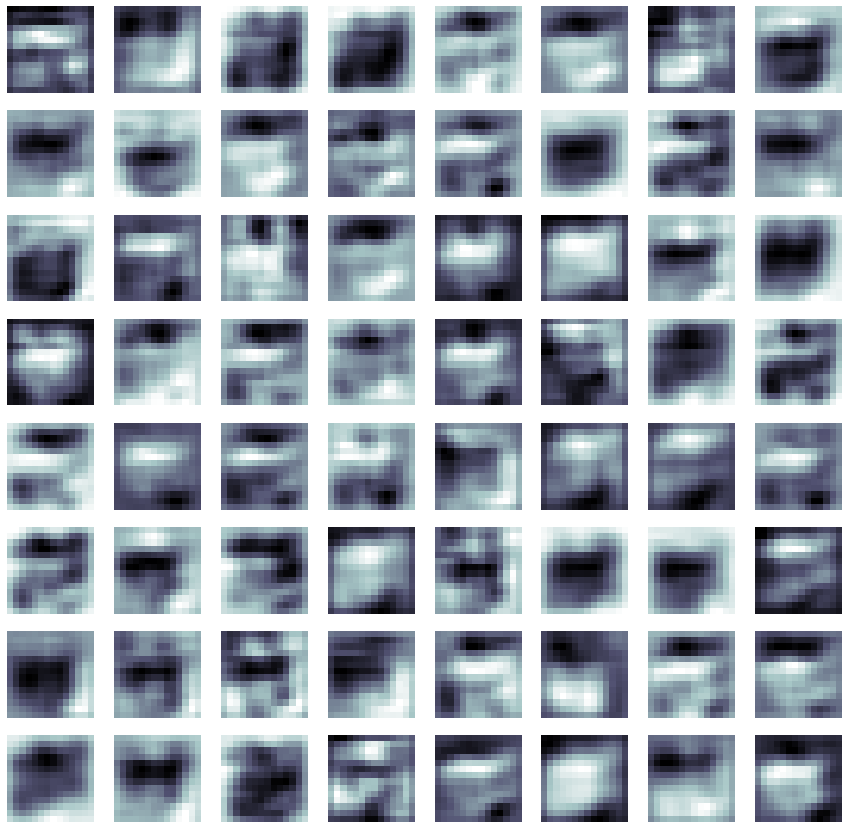

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
cont=4
for num_layer in range(len(outputs)):
    cont+=1
    if cont%5==0:
      plt.figure(figsize=(15, 15))
      layer_viz = outputs[num_layer][0, :, :, :]
      layer_viz = layer_viz.data
      print(layer_viz.size())
      for i, filter in enumerate(layer_viz):
          if i == 64: # we will visualize only 8x8 blocks from each layer
              break
          plt.subplot(8, 8, i + 1)
          plt.imshow(filter.detach().cpu().numpy(), cmap='bone')
          #plt.imshow(filter.detach().cpu().numpy(), cmap='gray')
          plt.axis("off")
      print(f"Saving layer {num_layer} feature maps...")
      #plt.savefig(f"layer_{num_layer}.png")
      plt.show()
      plt.close()
    else:
      continue

#Last layer
last_layer=len(outputs)-1
plt.figure(figsize=(15, 15))
layer_viz = outputs[last_layer][0, :, :, :]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    if i == 64: # we will visualize only 8x8 blocks from each layer
        break
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.detach().cpu().numpy(), cmap='bone')
    #plt.imshow(filter.detach().cpu().numpy(), cmap='gray')
    plt.axis("off")
print(f"Saving last layer {last_layer} feature maps...")
#plt.savefig(f"layer_{num_layer}.png")
plt.show()
plt.close()